In [1]:
import pandas as pd
import numpy as np

import requests
import json

import csv
import matplotlib.pyplot as plt
import seaborn as sns

import os

import datetime
import chess.pgn

In [ ]:
import requests

def get_player_games(username):
    # Set the username and API endpoint
    username = username.lower()
    api_url = f"https://lichess.org/api/games/user/{username}"

    # Set the request headers
    headers = {
        "Accept": "application/x-chess-pgn"
    }

    try:
        # Send a GET request to the API endpoint
        response = requests.get(api_url, headers=headers)
        response.raise_for_status()  # Raise an exception if the request fails

        # Get the games data from the response
        games_data = response.text

        # Save the games data to a PGN file
        with open(f"{username}_games.pgn", "w", encoding="utf-8") as file:
            file.write(games_data)

        print(f"Successfully saved {username}'s games to {username}_games.pgn")

    except requests.exceptions.RequestException as e:
        print(f"Error retrieving {username}'s games:", str(e))

# Call the method with the desired username
get_player_games('nihalsarin2004')


In [3]:
def create_dataset_from_pgn(pgn_file):
    """
    Creates a dataset from a PGN file.

    Args:
        pgn_file (str): The path to the PGN file.

    Returns:
        pd.DataFrame: A pandas DataFrame representing the dataset.
    """
    games = []

    with open(pgn_file) as file:
        while True:
            try:
                game = chess.pgn.read_game(file)
            except:
                continue
                
            if game is None:
                break

            try:
                moves = [move.uci() for move in game.mainline_moves()]
                
                # Attempt to parse the moves and check for illegal moves
                board = chess.Board()
                for move in moves:
                    board.push_uci(move)
                
            except chess.IllegalMoveError:
                # Skip games with illegal moves
                continue
                
            # Extract desired information from the game
            player1 = game.headers.get('White', 'Unknown Player 1')
            player2 = game.headers.get('Black', 'Unknown Player 2')
            rating1 = game.headers.get('WhiteElo', '0')
            rating2 = game.headers.get('BlackElo', '0')
            moves = [move.uci() for move in game.mainline_moves()]
            opening = game.headers.get('ECO' , 'Other')
            outcome = game.headers.get('Result', '*')
            move_count = len(moves)
            
            if isinstance(rating1, str) and rating1.isdigit():
                rating1 = int(rating1)
            else:
                rating1 = 0

            if isinstance(rating2, str) and rating2.isdigit():
                rating2 = int(rating2)
            else:
                rating2 = 0


            # Create a dictionary representing the game
            game_data = {
                'White': player1,
                'Elo_White': rating1,
                'Black': player2,
                'Elo_Black': rating2,
                'Outcome': outcome,
                'ECO': opening,
                'Moves': moves,
                'Move_Count': move_count
            }

            games.append(game_data)

    # Convert the list of games into a pandas DataFrame
    dataset = pd.DataFrame(games)

    return dataset

In [4]:
pgn_file = 'games.pgn'
dataset = create_dataset_from_pgn(pgn_file)

# Display the dataset
print(dataset)

error during pgn parsing
Traceback (most recent call last):
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\__init__.py", line 3062, in parse_san
    raise IllegalMoveError(f"illegal san: {san!r} in {self.fen()}")
chess.IllegalMoveError: illegal san: 'd5' in rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
error during pgn parsing
Traceback (most recent call last):
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\chess\pgn.py", line 1059, 

                               White  Elo_White  \
0                                  ?          0   
1                                  ?          0   
2                   Merkistein, Suni       1901   
3             Thorsteinsson, Sjurdur       2127   
4                       Joensen, Oli       1785   
...                              ...        ...   
43170          Anton Guijarro, David       2679   
43171  Cuenca Jimenez, Jose Fernando       2506   
43172     Fernandez, Maria Florencia       2229   
43173    Iturrizaga Bonelli, Eduardo       2607   
43174           Narciso Dublan, Marc       2520   

                               Black  Elo_Black  Outcome    ECO  \
0                                  ?          0  1/2-1/2  Other   
1                                  ?          0  1/2-1/2  Other   
2            Apol, Luitjen Akselsson       2126      1-0    E62   
3               Dalsgard, Arnbjorn O       1881      1-0    A43   
4                     Hansen, Herluf       1971     

In [5]:
def handle_missing_values(df):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Remove rows or columns with missing values
    df = df.dropna(axis=0)  # Remove rows with missing values

    return df

In [6]:
def count_moves(moves):
    num_moves = len(moves)
    return num_moves

In [7]:
def drop_short_games(data):
    data['MoveCount'] = data['Moves'].apply(count_moves)
    filtered_data = data[data['MoveCount'] >= 5]
    filtered_data = filtered_data.drop('MoveCount', axis=1)
    return filtered_data

In [8]:
def clean_data(df):
    # Drop games with missing player ratings
    df = df.dropna(subset=['Elo_White', 'Elo_Black'])
    
    # Check for large values in Elo columns
    max_elo = 3000  # Set a reasonable maximum Elo rating
    df = df[(df['Elo_White'] <= max_elo) & (df['Elo_Black'] <= max_elo)]

    # Remove irrelevant columns
    df = df.drop(['White', 'Black'], axis=1)
    df = df[df['ECO'] != 'Other']
    return df

In [9]:
# Clean the data
cleaned_data = clean_data(dataset)

# Handle missing values
processed_data = handle_missing_values(cleaned_data)

print(processed_data)

       Elo_White  Elo_Black Outcome  ECO  \
2           1901       2126     1-0  E62   
3           2127       1881     1-0  A43   
4           1785       1971     0-1  E14   
5           2193       2026     1-0  C52   
6           1990       2061     0-1  B09   
...          ...        ...     ...  ...   
43170       2679       2335     1-0  A49   
43171       2506       2331     0-1  D37   
43172       2229       2308     0-1  D60   
43173       2607       2376     1-0  A14   
43174       2520       2392     1-0  B26   

                                                   Moves  Move_Count  
2      [g1f3, g8f6, c2c4, g7g6, g2g3, f8g7, f1g2, e8g...          93  
3      [d2d4, e7e6, c2c4, c7c5, d4d5, e6d5, c4d5, d7d...          51  
4      [d2d4, g8f6, c2c4, e7e6, g1f3, b7b6, e2e3, c8b...          86  
5      [e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, b2b4, c5b...         109  
6      [e2e4, d7d6, d2d4, g8f6, b1c3, g7g6, f2f4, f8g...          62  
...                                          

In [10]:
opening_dict = {
    'A00-A39': 'Irregular Openings',
    'A40-A41': 'Queen\'s Pawn',
    'A42': 'Modern Defense',
    'A43-A44': 'Old Benoni Defense',
    'A45-A46': 'Queen\'s Pawn Game',
    'A47': 'Queen\'s Indian Defense',
    'A48-A49': 'King\'s Indian, East Indian Defense',
    'A50': 'Queen\'s Pawn Game',
    'A51-A52': 'Budapest Defense',
    'A53-A55': 'Old Indian Defense',
    'A56': 'Benoni Defense',
    'A57-A59': 'Benko Gambit',
    'A60-A79': 'Benoni Defense',
    'A80-A99': 'Dutch Defense',
    'B00': 'King\'s Pawn',
    'B01': 'Scandinavian Defense',
    'B02-B05': 'Alekhine\'s Defense',
    'B06': 'Robatsch Defense',
    'B07-B09': 'Pirc Defense',
    'B10-B19': 'Caro-Kann Defense',
    'B20-B99': 'Sicilian Defense',
    'C00-C19': 'French Defense',
    'C20': 'King\'s Pawn Game',
    'C21-C22': 'Center Game',
    'C23-C24': 'Bishop\'s Opening',
    'C25-C29': 'Vienna Game',
    'C30-C39': 'King\'s Gambit',
    'C40': 'King\'s Knight Opening',
    'C41': 'Philidor\'s Defense',
    'C42-C43': 'Petrov\'s Defense',
    'C44': 'King\'s Pawn Game',
    'C45': 'Scotch Game',
    'C46': 'Three Knights Game',
    'C47-C49': 'Four Knights',
    'C50': 'Italian Game',
    'C51-C52': 'Evans Gambit',
    'C53-C54': 'Giuoco Piano',
    'C55-C59': 'Two Knights Defense',
    'C60-C99': 'Ruy Lopez (Spanish Opening)',
    'D00': 'Queen\'s Pawn Game',
    'D01': 'Richter-Veresov Attack',
    'D02': 'Queen\'s Pawn Game',
    'D03': 'Torre Attack',
    'D04-D05': 'Queen\'s Pawn Game',
    'D06': 'Queen\'s Gambit',
    'D07-D09': 'Queen\'s Gambit Declined',
    'D10-D15': 'Queen\'s Gambit Declined Slav Defense',
    'D16': 'Queen\'s Gambit Declined Slav Accepted',
    'D17-D19': 'Queen\'s Gambit Declined Slav, Czech Defense',
    'D20-D29': 'Queen\'s Gambit Accepted',
    'D30-D42': 'Queen\'s Gambit Declined',
    'D43-D49': 'Queen\'s Gambit Declined Semi-Slav Defense',
    'D50-D69': 'Queen\'s Gambit Declined',
    'D70-D79': 'Neo-Gruenfeld Defense',
    'D80-D99': 'Gruenfeld Defense',
    'E00': 'Queen\'s Pawn Game',
    'E01-E09': 'Catalan Opening',
    'E10-E19': 'Queen\'s Pawn Game',
    'E20-E59': 'Nimzo-Indian Defense',
    'E60-E99': 'King\'s Indian Defense'
}

In [11]:
def opening_name(opening):
    opening_name = None
    for eco_range, opening_value in opening_dict.items():
        if '-' in eco_range:
            range_start, range_end = eco_range.split('-')
            if opening >= range_start and opening <= range_end:
                opening_name = opening_value
                break
        else:
            if opening == eco_range:
                opening_name = opening_value
                break
    return opening_name


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_popular_openings(data):
    # Group the data by ECO code and count the number of occurrences
    opening_counts = data['ECO'].value_counts().nlargest(10)

    # Extract the ECO codes and their corresponding counts
    eco_codes = opening_counts.index.tolist()
    game_counts = opening_counts.values.tolist()

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(eco_codes, game_counts)

    # Set the plot title and labels
    plt.title('Top 10 Most Popular Openings by ECO Code')
    plt.xlabel('ECO Code')
    plt.ylabel('Number of Games Played')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Display the plot
    plt.show()
    return eco_codes


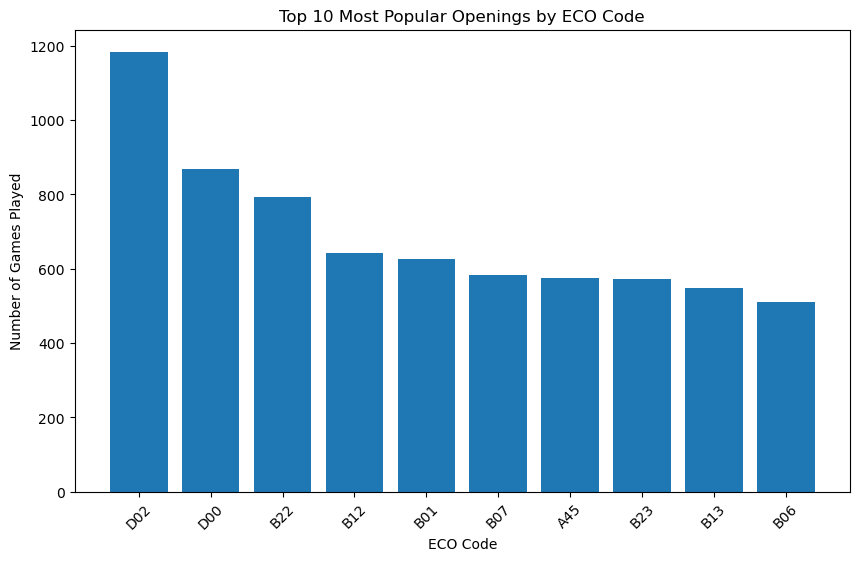

In [13]:
popular_eco_codes = plot_popular_openings(processed_data)

In [14]:
def filter_games_by_rating_range(min_rating, max_rating, dataset):
    """
    Filters games from the dataset based on the specified rating range.

    Args:
        min_rating (int): The minimum rating of the range.
        max_rating (int): The maximum rating of the range.
        dataset (pd.DataFrame): The dataset containing the games.

    Returns:
        pd.DataFrame: The filtered dataset.
    """
    filtered_dataset = dataset[
        (dataset['Elo_White'] >= min_rating) & (dataset['Elo_White'] <= max_rating) &
        (dataset['Elo_Black'] >= min_rating) & (dataset['Elo_Black'] <= max_rating)
    ]

    return filtered_dataset

In [15]:
def filter_games_by_opening(opening, dataset):
    # Filter the dataset by the opening
    filtered_dataset = dataset[dataset['ECO'] == opening]

    return filtered_dataset

In [16]:
def plot_opening_by_rating(opening, dataset):
    # Initialize empty lists for ratings and frequencies
    ratings = []
    frequencies = []

    # Iterate through rating ranges starting from 1000 with 300 points in each range until 3000
    for min_rating in range(1000, 3001, 300):
        max_rating = min_rating + 299

        # Filter the dataset by rating range
        filtered_games = filter_games_by_rating_range(min_rating, max_rating, dataset)
       
        # Filter the dataset by the opening
        filtered_dataset = filter_games_by_opening(opening, filtered_games)


        # Calculate the frequency of the opening in the rating range
        frequency = len(filtered_dataset)

        # Append the rating and frequency to the lists
        ratings.append(f"{min_rating}-{max_rating}")
        frequencies.append(frequency)

    # Create the bar chart
    plt.bar(ratings, frequencies)
    plt.xlabel("Rating Range")
    plt.ylabel("Times Played")
    plt.title(f"Opening : "+ opening + " " + opening_name(opening))
    plt.xticks(rotation=45)
    plt.show()

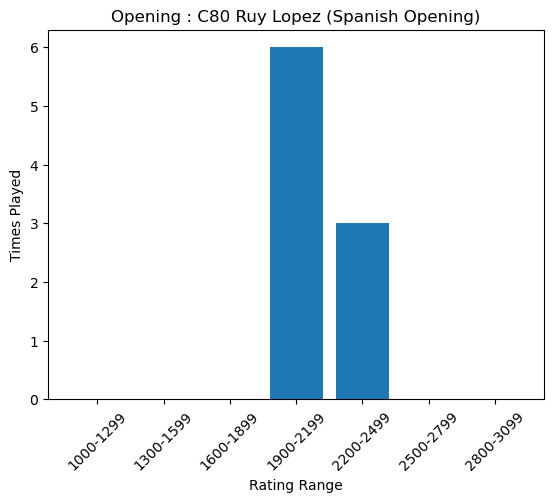

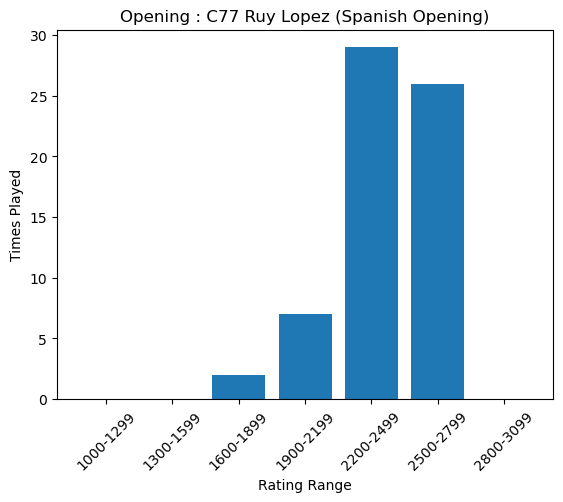

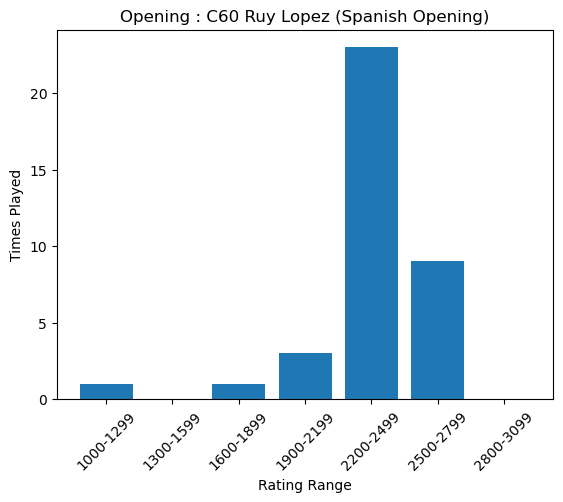

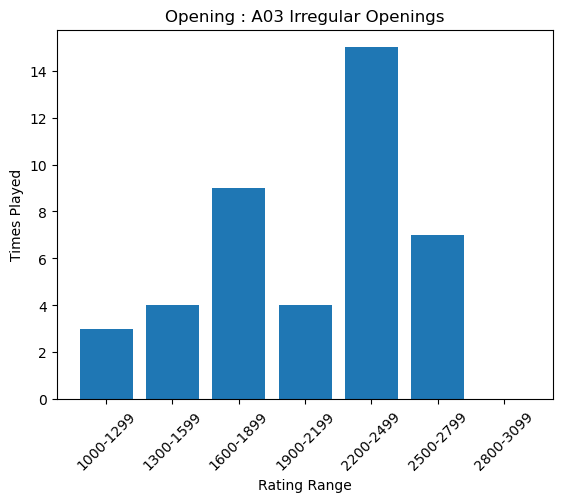

In [17]:
plot_opening_by_rating('C80' , processed_data)
plot_opening_by_rating('C77' , processed_data)
plot_opening_by_rating('C60' , processed_data)
plot_opening_by_rating('A03' , processed_data)


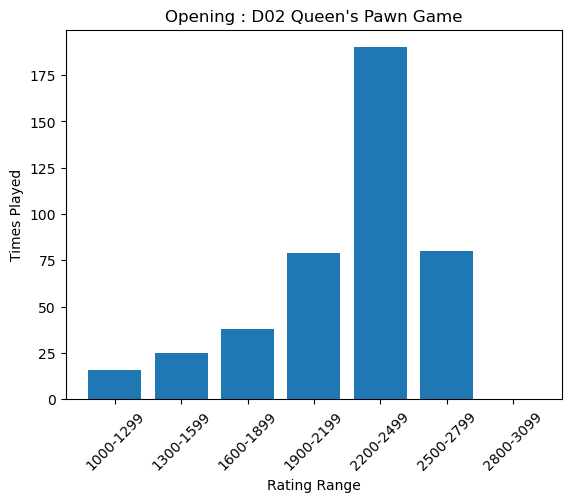

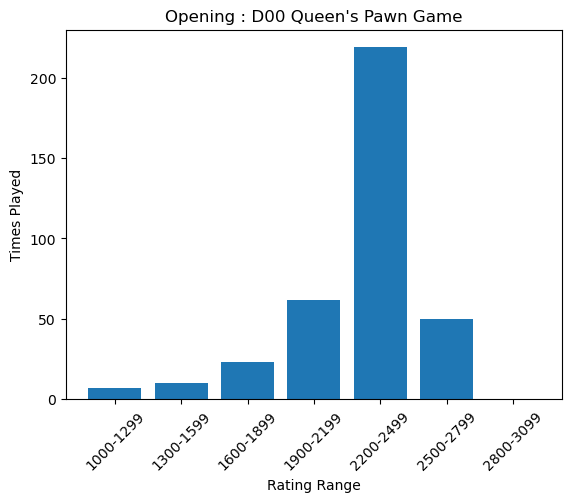

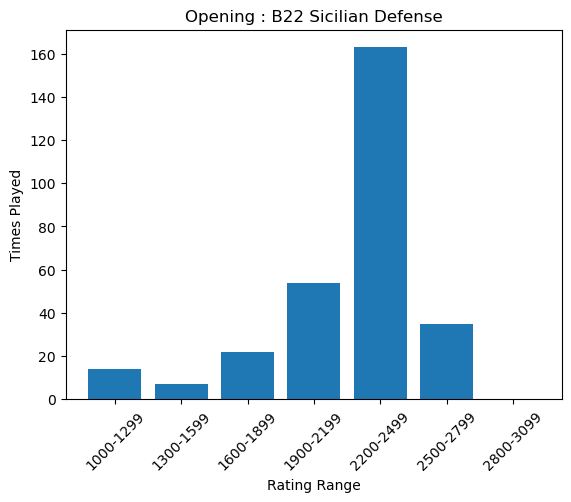

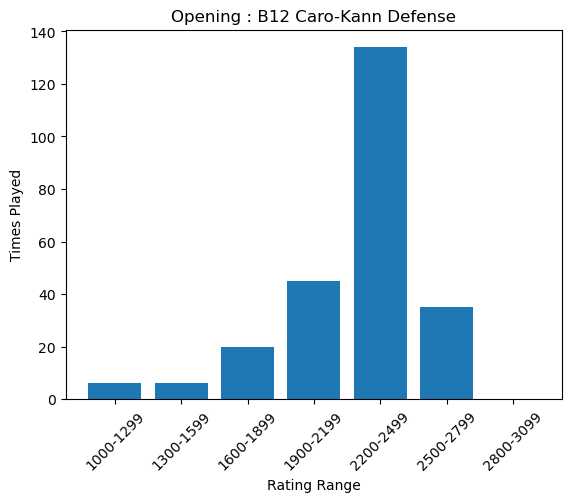

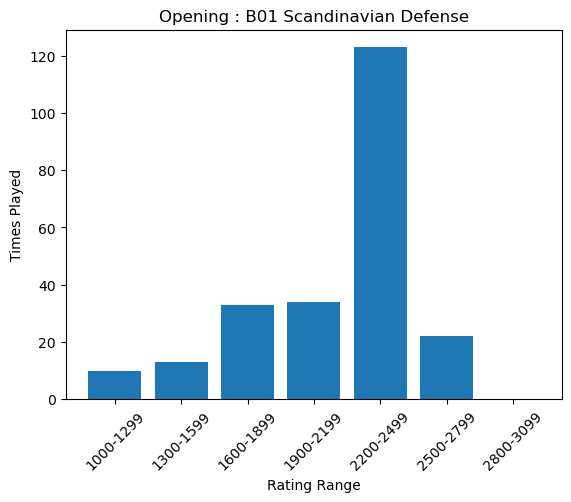

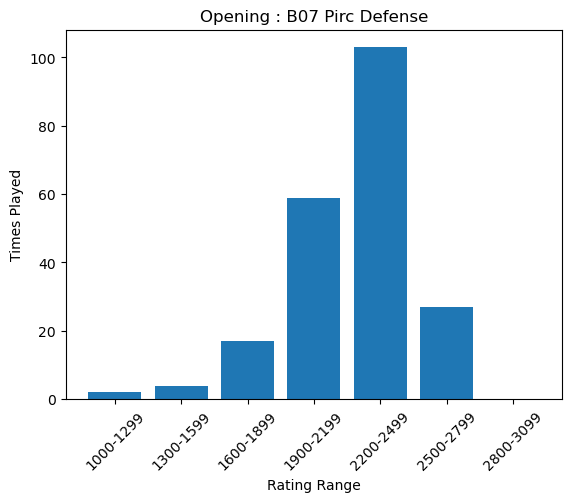

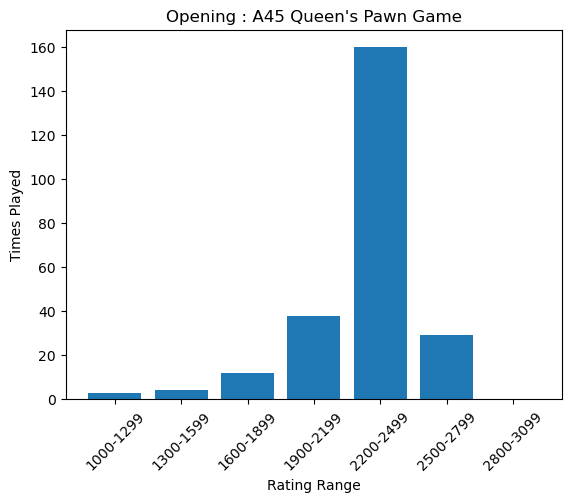

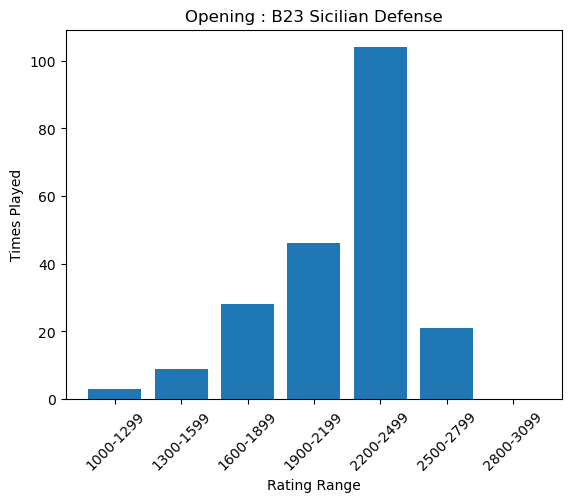

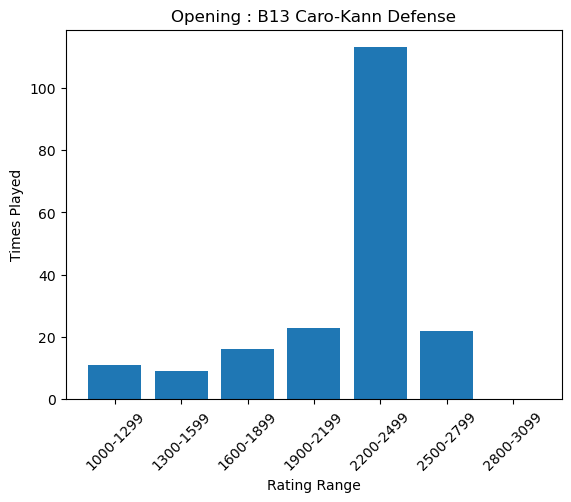

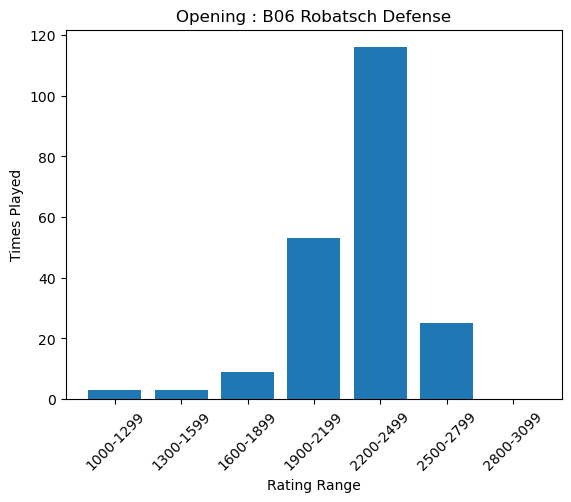

In [18]:
for opening in popular_eco_codes:
    plot_opening_by_rating(opening , processed_data)
    

In [19]:
def create_opening_pie_chart(opening, dataset):
    filtered_games = dataset[dataset['ECO'] == opening]
    total_games = len(filtered_games)
    
    if total_games == 0:
        print(f"No games found for opening: {opening}")
        return
            
    win_count = len(filtered_games[filtered_games['Outcome'] == '1-0'])
    lose_count = len(filtered_games[filtered_games['Outcome'] == '0-1'])
    draw_count = len(filtered_games[filtered_games['Outcome'] == '1/2-1/2'])

    win_percentage = (win_count / total_games) * 100
    lose_percentage = (lose_count / total_games) * 100
    draw_percentage = (draw_count / total_games) * 100

    labels = ['Win', 'Lose', 'Draw']
    sizes = [win_percentage, lose_percentage, draw_percentage]
    colors = ['green', 'red', 'yellow']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title(f"Opening:"+ opening + " " + opening_name(opening) + "- Games Played:" + str(total_games))
    plt.show()


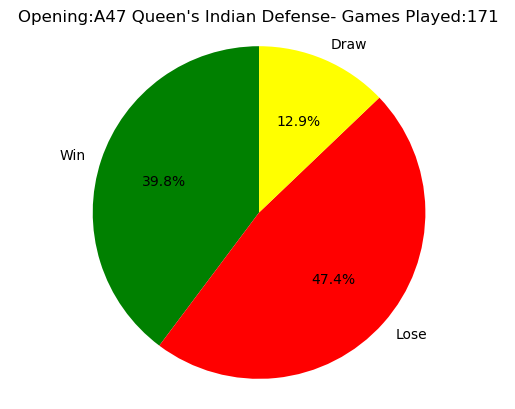

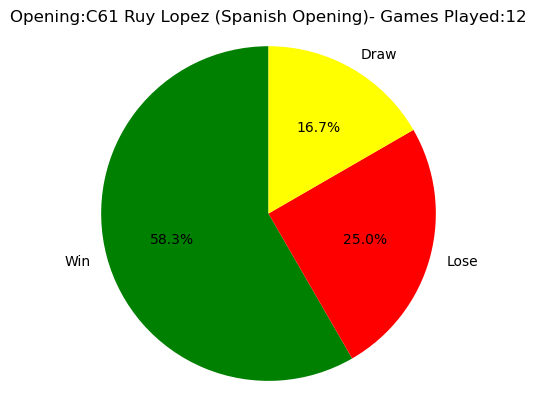

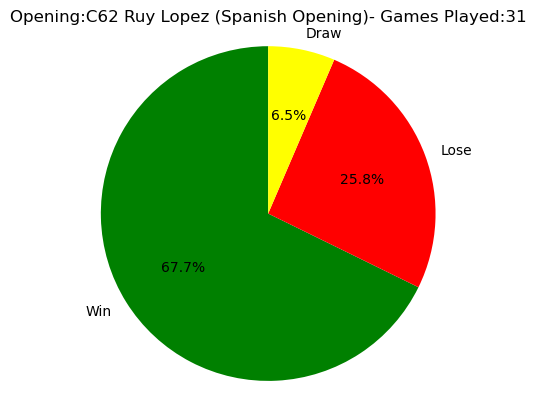

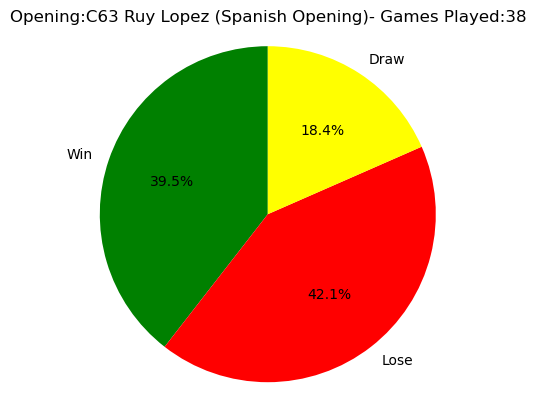

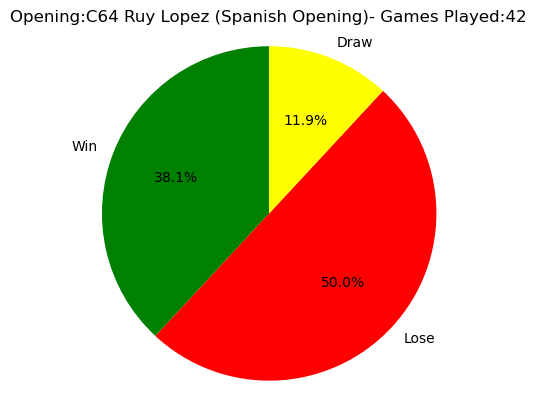

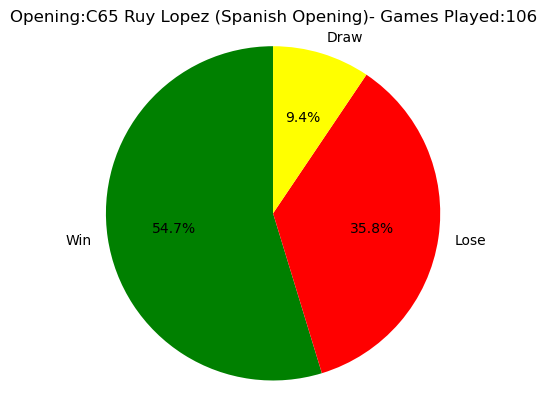

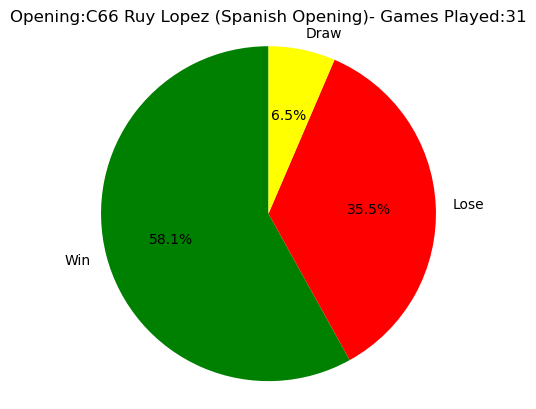

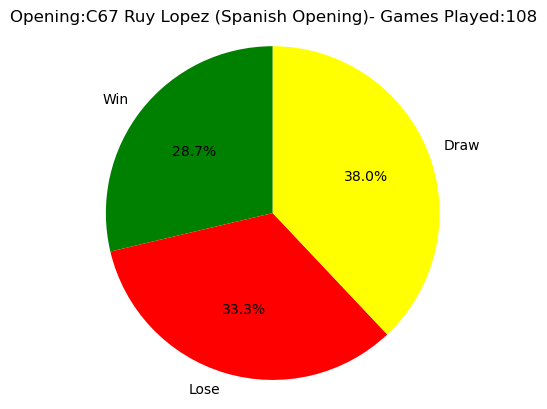

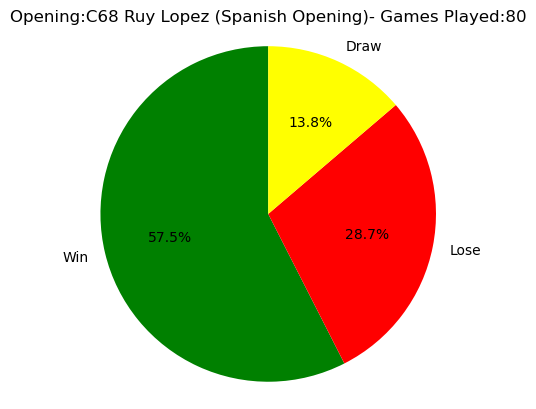

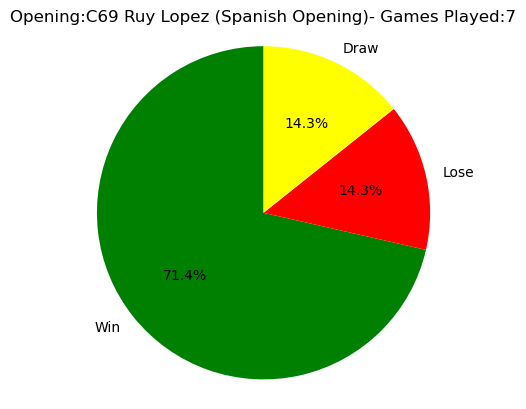

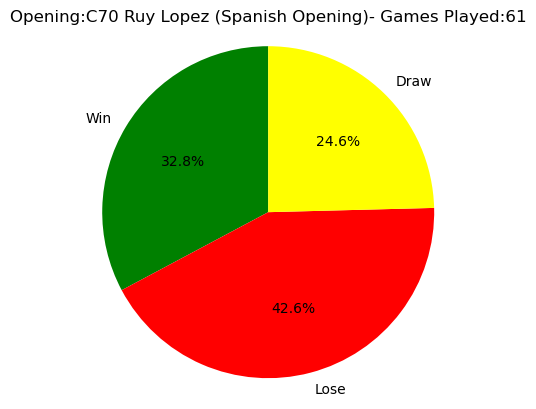

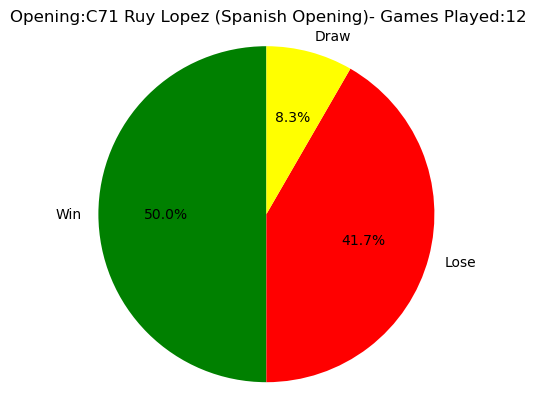

In [20]:
create_opening_pie_chart('A47', processed_data)
create_opening_pie_chart('C61', processed_data)
create_opening_pie_chart('C62', processed_data)
create_opening_pie_chart('C63', processed_data)
create_opening_pie_chart('C64', processed_data)
create_opening_pie_chart('C65', processed_data)
create_opening_pie_chart('C66', processed_data)
create_opening_pie_chart('C67', processed_data)
create_opening_pie_chart('C68', processed_data)
create_opening_pie_chart('C69', processed_data)
create_opening_pie_chart('C70', processed_data)
create_opening_pie_chart('C71', processed_data)



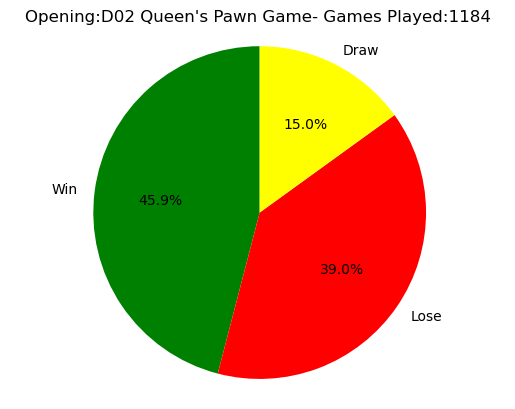

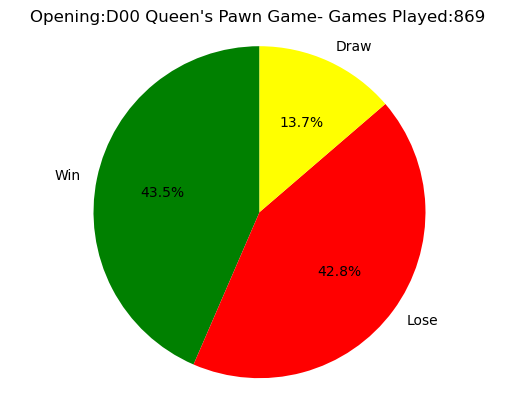

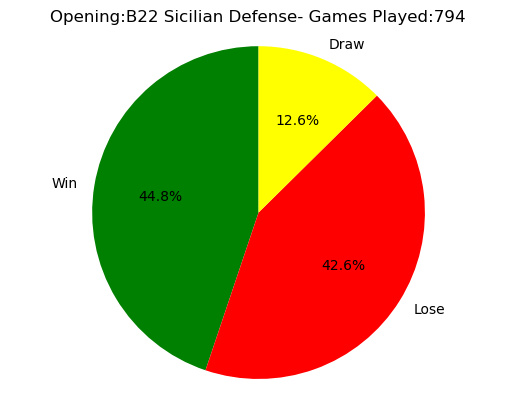

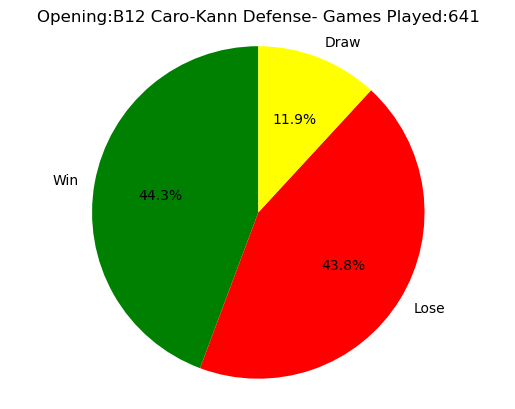

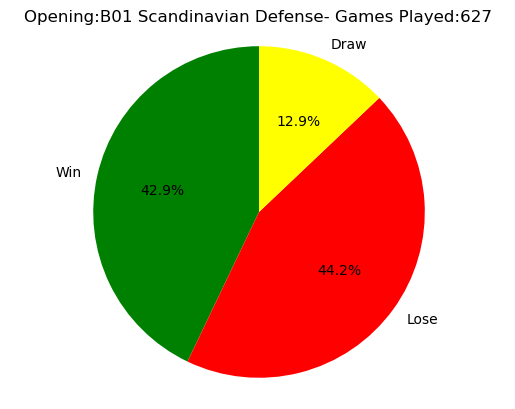

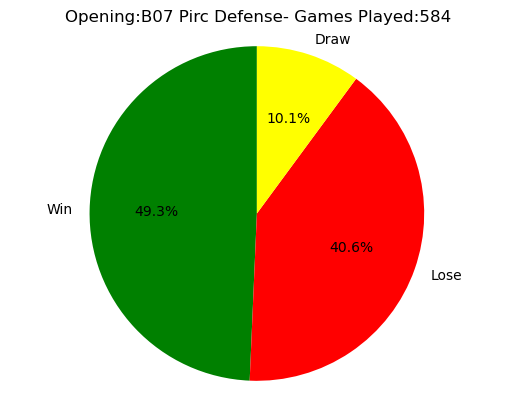

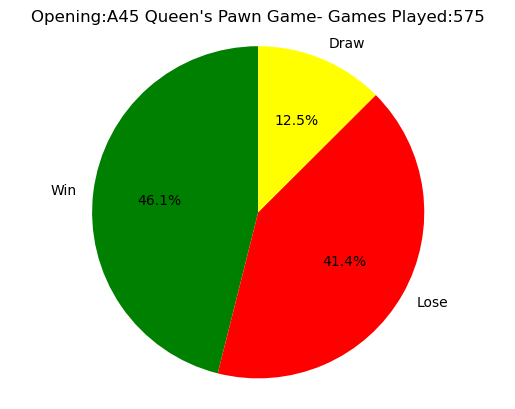

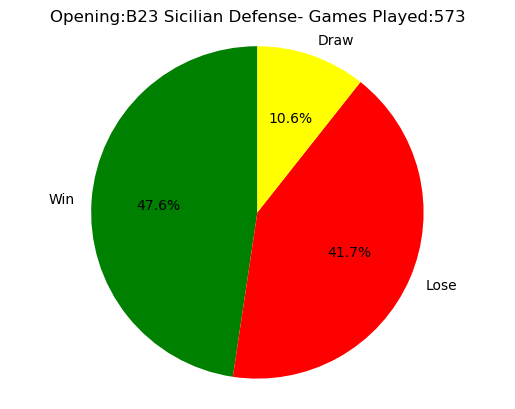

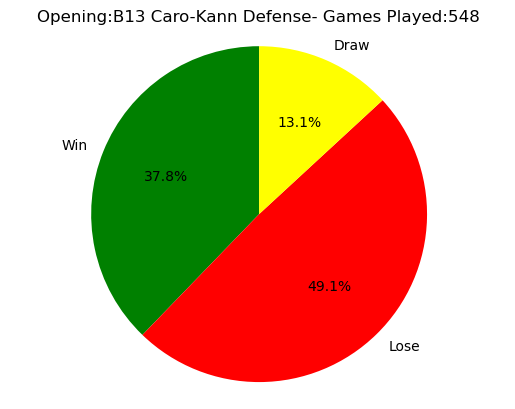

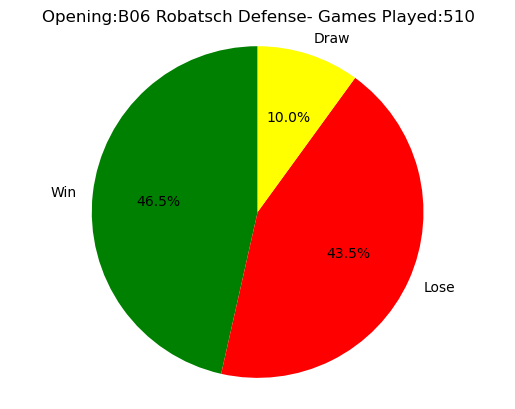

In [21]:
for opening in popular_eco_codes:
    create_opening_pie_chart(opening , processed_data)

In [22]:
import matplotlib.pyplot as plt

def plot_rating_vs_win_percentage(opening, dataset):
    filtered_dataset = filter_games_by_opening(opening, dataset)
    ratings, win_percentages = calculate_rating_and_win_percentages(filtered_dataset)

    plt.scatter(ratings, win_percentages)
    plt.xlabel('Rating')
    plt.ylabel('Win Percentage')
    plt.title(f'Rating vs Win Percentage for Opening {opening}')
    plt.xticks(rotation=70)  # Rotate x-axis tick labels by 45 degrees for better readability
    plt.show()

In [23]:
def calculate_rating_and_win_percentages(dataset):
    min_rating = dataset['Elo_White'].min()
    max_rating = dataset['Elo_White'].max()
    rating_ranges = range(min_rating, max_rating + 50, 50)  # Create rating ranges with a step of 10
    win_percentages = []
    rating_groups = []

    for i in range(len(rating_ranges) - 1):
        min_range = rating_ranges[i]
        max_range = rating_ranges[i + 1]
        games_with_rating = dataset[
            (dataset['Elo_White'] >= min_range) & (dataset['Elo_White'] < max_range)
        ]
        total_games = len(games_with_rating)
        
        # Skip the rating range if no games were played
        if total_games == 0:
            continue
        
        win_count = len(games_with_rating[games_with_rating['Outcome'] == '1-0'])
        win_percentage = (win_count / total_games) * 100
        rating_groups.append(f'{max_range}')  # Store the rating range as a string
        win_percentages.append(win_percentage)

    return rating_groups, win_percentages


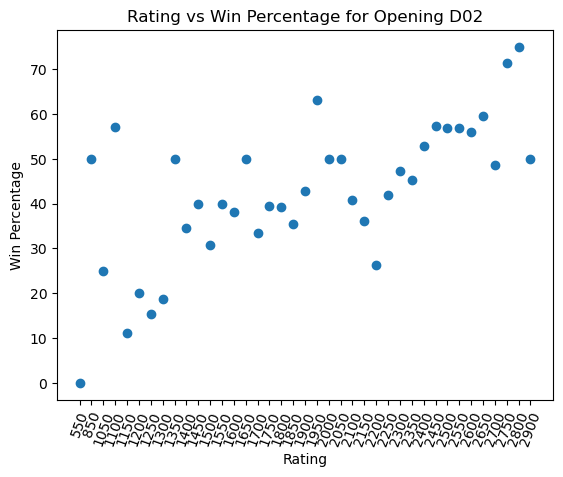

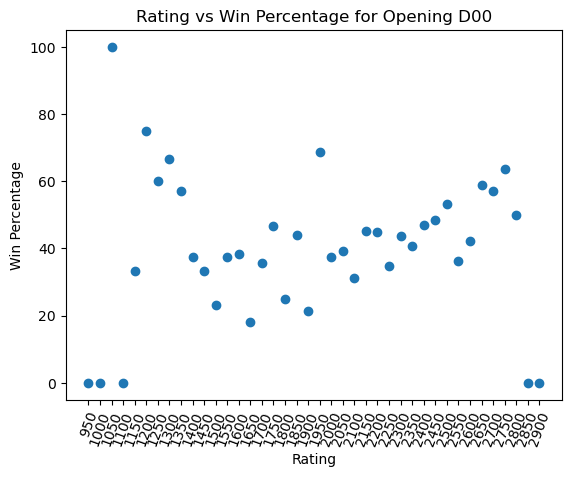

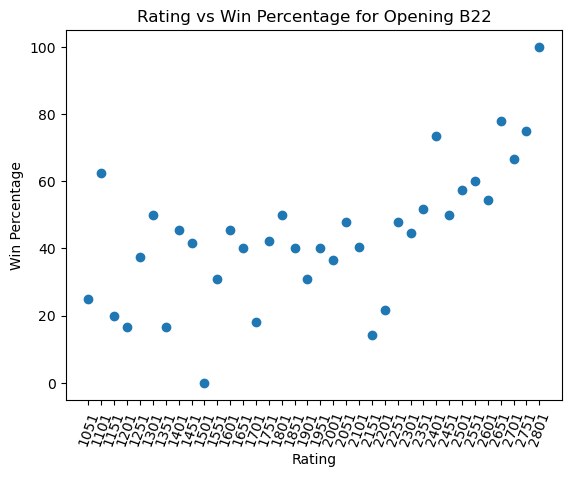

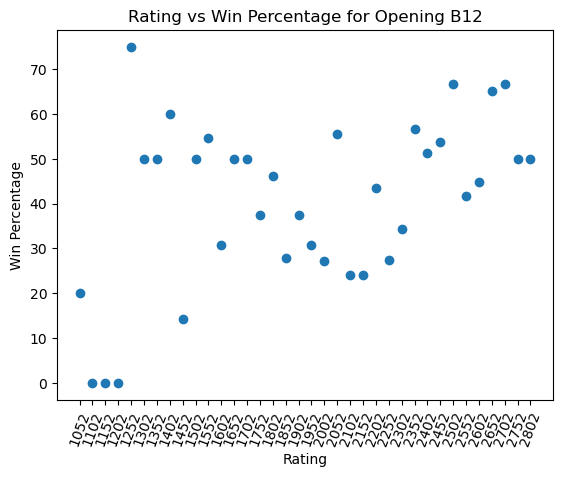

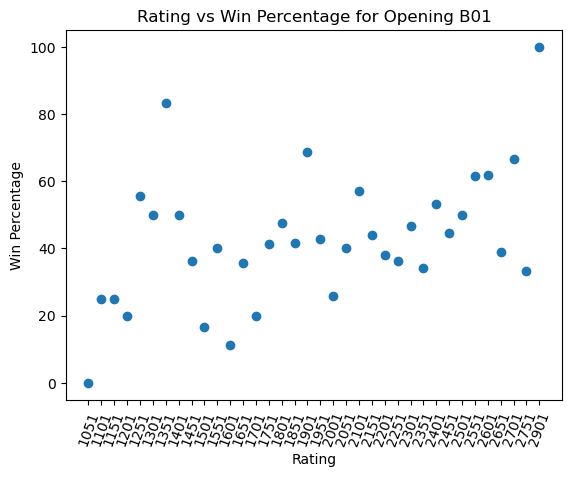

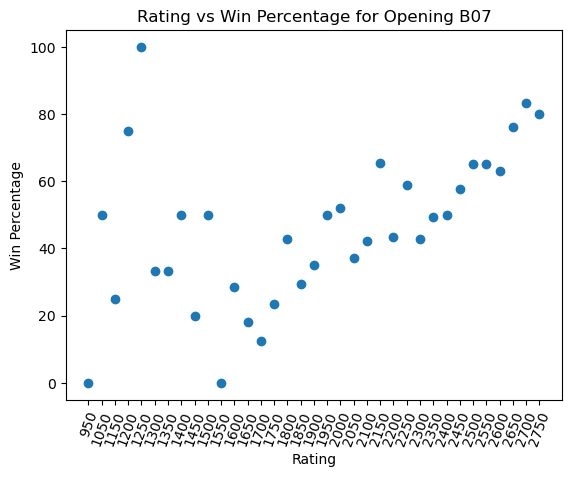

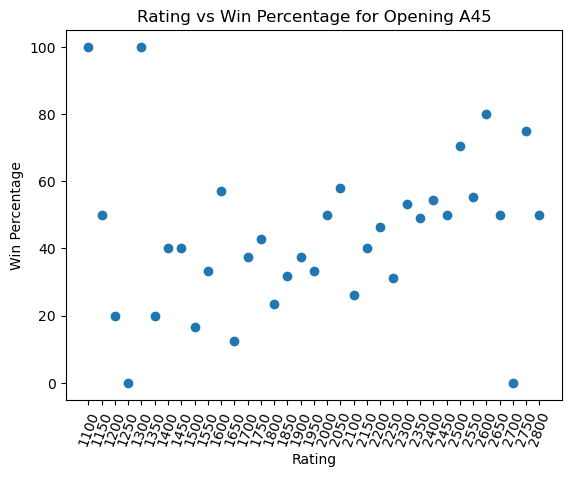

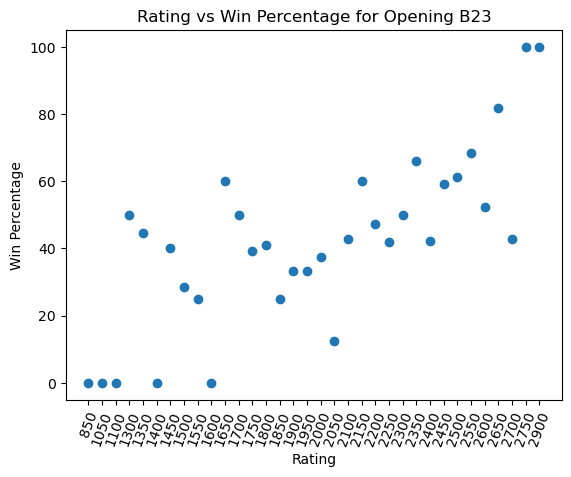

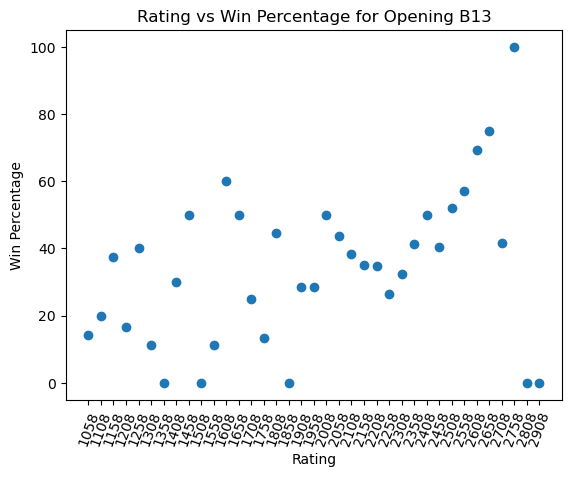

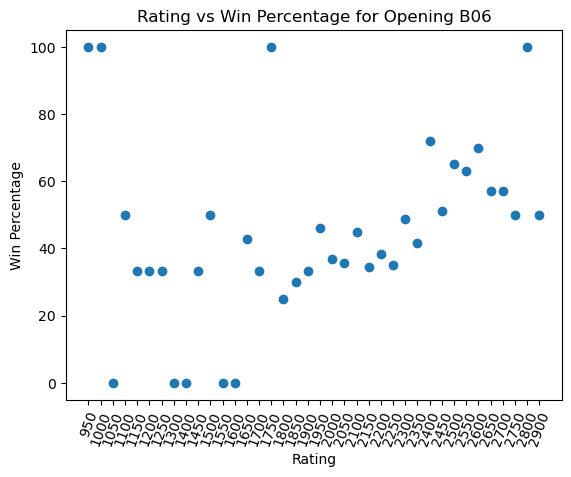

In [24]:
for opening in popular_eco_codes:
    plot_rating_vs_win_percentage(opening , processed_data)

In [25]:
def plot_moves_vs_win_percentage(opening, dataset):
    filtered_dataset = dataset[dataset['ECO'] == opening]
    move_counts = filtered_dataset['Move_Count']
    win_percentages = []

    # Define the move count ranges
    move_ranges = np.arange(0, max(move_counts) + 11, 10)

    for i in range(len(move_ranges) - 1):
        min_range = move_ranges[i]
        max_range = move_ranges[i+1]
        games_within_range = filtered_dataset[
            (filtered_dataset['Move_Count'] >= min_range) &
            (filtered_dataset['Move_Count'] < max_range)
        ]
        total_games = len(games_within_range)

        if total_games > 0:
            win_count = len(games_within_range[games_within_range['Outcome'] == '1-0'])
            win_percentage = (win_count / total_games) * 100
            win_percentages.append(win_percentage)
        else:
            win_percentages.append(0)  # Add a 0 win percentage for empty ranges

    # Check if there are win percentages to plot
    if len(win_percentages) > 0:
        # Plotting
        plt.bar(move_ranges[:-1], win_percentages, align='edge', width=10)
        plt.xlabel('Number of Moves Played')
        plt.ylabel('Win Percentage')
        plt.title(f'Number of Moves Played vs Win Percentage for Opening {opening}')
        plt.show()
    else:
        print(f"No data available for opening {opening}.")

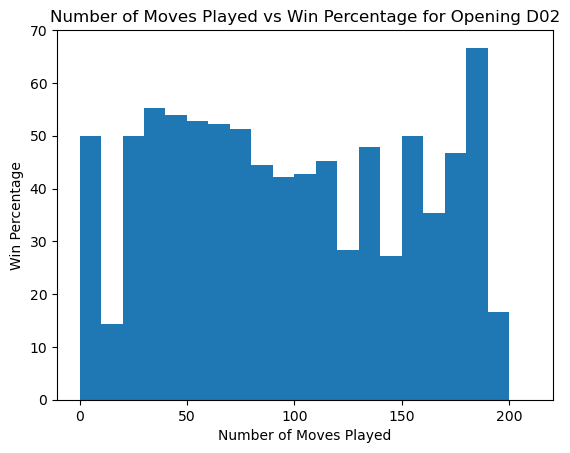

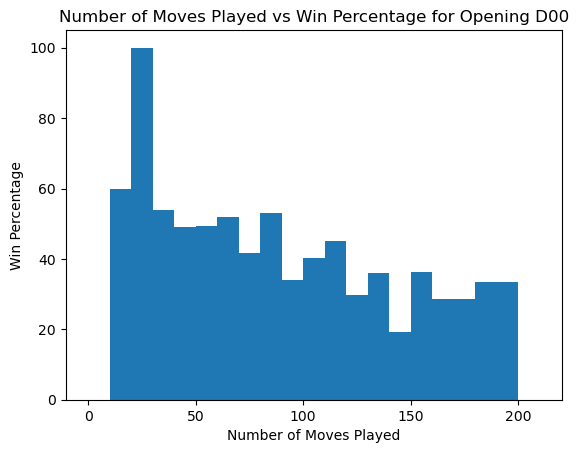

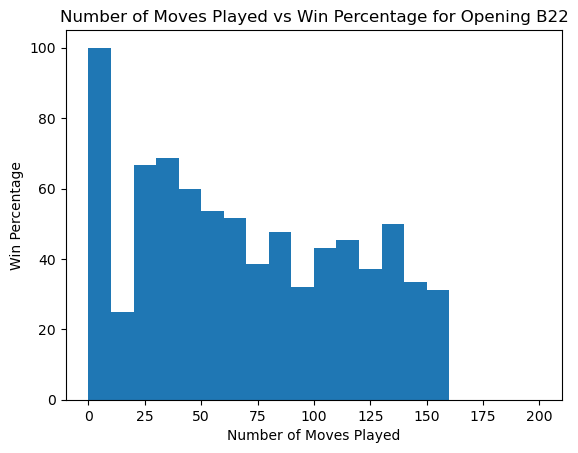

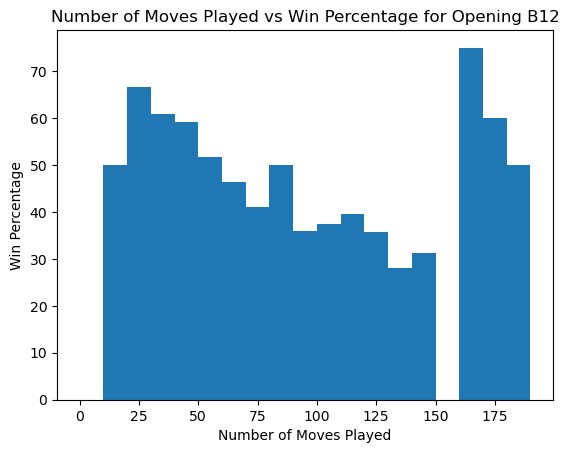

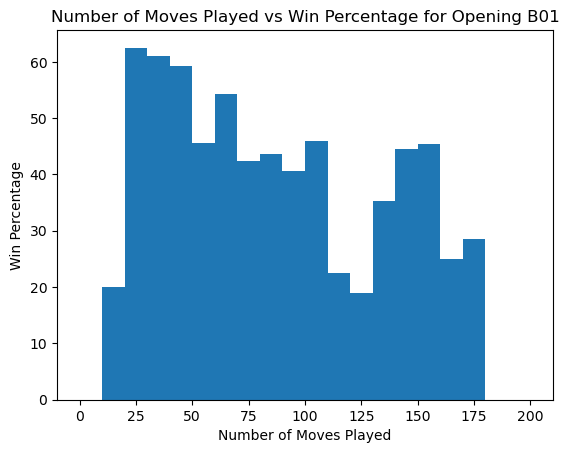

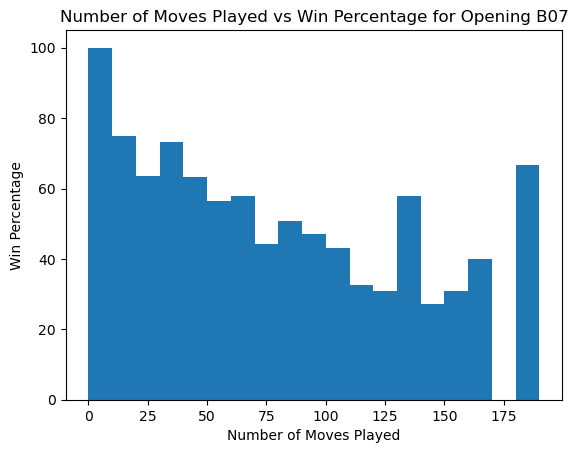

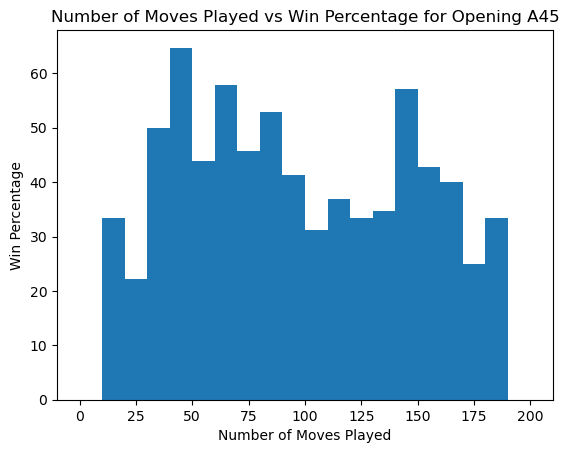

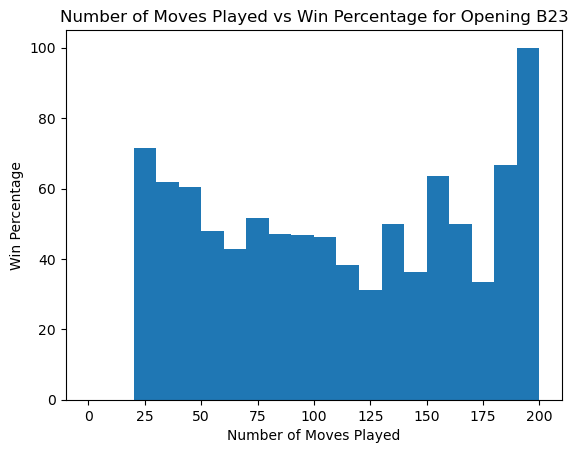

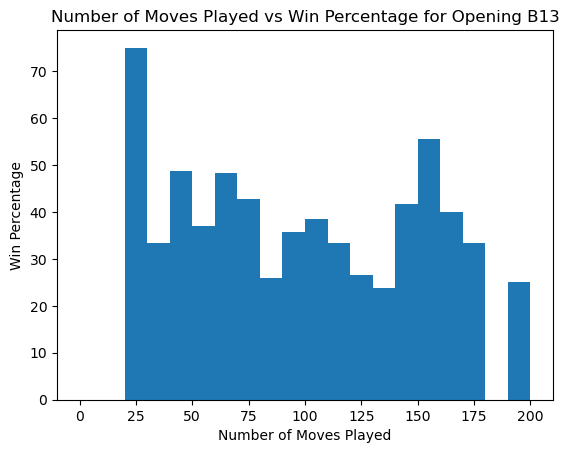

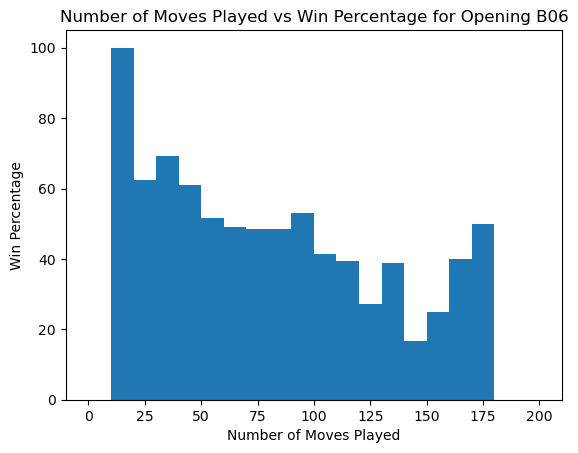

In [26]:
for opening in popular_eco_codes:
    plot_moves_vs_win_percentage(opening , processed_data)

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

def preprocess_data(dataset):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    dataset['Outcome'] = label_encoder.fit_transform(dataset['Outcome'])

    # Split the data into features and target variable
    X = dataset[['Elo_White', 'Elo_Black', 'ECO', 'Move_Count']]
    y = dataset['Outcome']

    # One-hot encode categorical variable 'ECO'
    X = pd.get_dummies(X, columns=['ECO'])
    
    X.to_csv('encoded_columns.csv', index=False)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    return X_train, X_test, y_train, y_test


In [110]:
from sklearn.linear_model import LogisticRegression

def train_model(X_train, y_train):
    # Create a logistic regression model
    model = LogisticRegression(penalty='l2')

    # Train the model
    model.fit(X_train, y_train)

    return model

In [114]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X_test, y_test):
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    
    # Generate classification report
    report = classification_report(y_test, y_pred)

    return accuracy, report

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def tune_model(X_train, y_train):
    # Define the parameter grid
    param_grid = {
        'penalty': ['l2', 'none'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }

    # Create the logistic regression model
    model = LogisticRegression(solver='lbfgs', max_iter=1000)

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Get the best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score:", best_score)

    return best_params


In [116]:
X_train, X_test, y_train, y_test = preprocess_data(processed_data)
model = train_model(X_train,y_train)
accuracy, report = evaluate_model(model,X_test,y_test)
best = tune_model(X_train, y_train)

C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rotte\OneDrive\rottem\school\data_sciense\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Best Parameters: {'C': 0.001, 'penalty': 'l2'}
Best Score: 0.6005443274863017


In [117]:
print(accuracy)
print(report)
print(best)

0.6042848870874349
              precision    recall  f1-score   support

           0       0.58      0.64      0.61      3442
           1       0.62      0.74      0.68      4044
           2       0.00      0.00      0.00      1149

    accuracy                           0.60      8635
   macro avg       0.40      0.46      0.43      8635
weighted avg       0.52      0.60      0.56      8635

{'C': 0.001, 'penalty': 'l2'}


In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate2_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    # Calculate ROC AUC score for each class and average them
    n_classes = len(np.unique(y_test))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='macro')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)



In [119]:
evaluate2_model(model, X_test, y_test)

Accuracy: 0.6042848870874349
Precision: 0.6042848870874349
Recall: 0.6042848870874349
F1 Score: 0.6042848870874349
ROC AUC Score: 0.6827549971444058


In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    labels = labels[:-1]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the confusion matrix
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


[0 1]


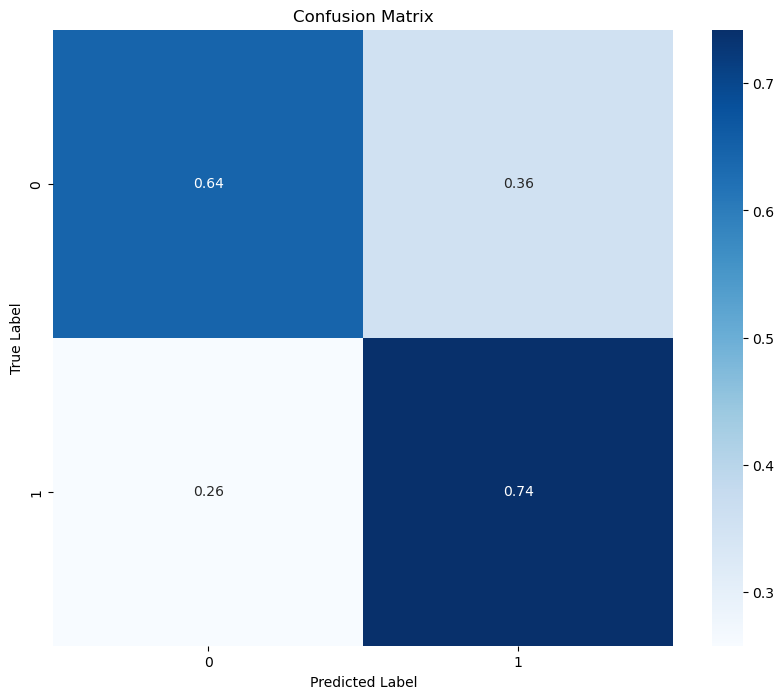

In [121]:
y_pred = model.predict(X_test)
unique_labels = np.unique(y_pred)
print(unique_labels)
display_confusion_matrix(y_test, y_pred)

In [122]:
import joblib
joblib.dump(model, 'trained_model.pkl')

['trained_model.pkl']

In [67]:
pgn_file = 'rottem_games.pgn'
dataset_rottem = create_dataset_from_pgn(pgn_file)

# Display the dataset
print(dataset_rottem)

                White  Elo_White              Black  Elo_Black Outcome  ECO  \
0              rottem       1893  PrinceOlistically       1882     1-0  C61   
1        piskarev_pvl       1881             rottem       1887     0-1  B19   
2              rottem       1893          Escalabar       1929     0-1  C71   
3              rottem       1889           SibiQazi       1777     1-0  B40   
4           mondmilch       1944             rottem       1893     1-0  D00   
...               ...        ...                ...        ...     ...  ...   
3928        fierakike       1333             rottem       1305     1-0  C20   
3929           rottem       1358         oualidlmt1       1451     0-1  C50   
3930           rottem       1453            MarthaC       1425     0-1  C55   
3931  Alex_Crackceres       1322             rottem       1339     0-1  C23   
3932        weetabixx       1531             rottem       1500     1-0  C47   

                                                  M

In [68]:
# Clean the data
cleaned_data = clean_data(dataset_rottem)

# Handle missing values
processed_data_rottem = handle_missing_values(cleaned_data)

print(processed_data_rottem)

      Elo_White  Elo_Black Outcome  ECO  \
0          1893       1882     1-0  C61   
1          1881       1887     0-1  B19   
2          1893       1929     0-1  C71   
3          1889       1777     1-0  B40   
4          1944       1893     1-0  D00   
...         ...        ...     ...  ...   
3928       1333       1305     1-0  C20   
3929       1358       1451     0-1  C50   
3930       1453       1425     0-1  C55   
3931       1322       1339     0-1  C23   
3932       1531       1500     1-0  C47   

                                                  Moves  Move_Count  
0     [e2e4, e7e5, g1f3, b8c6, f1b5, c6d4, f3d4, e5d...          27  
1     [e2e4, c7c6, d2d4, d7d5, b1d2, d5e4, d2e4, c8f...         110  
2     [e2e4, e7e5, g1f3, b8c6, f1b5, a7a6, b5a4, d7d...          34  
3     [e2e4, c7c5, g1f3, b8c6, d2d4, c5d4, f3d4, g8f...          81  
4     [d2d4, d7d5, c1g5, c7c5, c2c3, b8c6, e2e3, d8b...          17  
...                                                 ...        

In [ ]:
def count_variations(dataset, depth):
    variations = {}
    total_games = len(dataset)

    for index, row in dataset.iterrows():
        moves = row['Moves']
        variation = '-'.join(moves[:depth])

        if variation in variations:
            variations[variation] += 1
        else:
            variations[variation] = 1

    variation_percentages = {variation: (count / total_games) * 100 for variation, count in variations.items()}
    sorted_variations = sorted(variation_percentages.items(), key=lambda x: x[1], reverse=True)

    return sorted_variations


def plot_variations_by_rating_range(dataset, depth):
    rating_ranges = range(1000, 3100, 300)
    variation_counts = {}

    for range_start in rating_ranges:
        range_end = range_start + 299
        filtered_dataset = filter_games_by_rating_range(range_start, range_end, dataset)
        variation_counts[range_start] = count_variations(filtered_dataset, depth)

    most_popular_variations = {}

    for range_start, variations in variation_counts.items():
        if variations:
            total_games = sum(variation[1] for variation in variations)
            most_popular_variation = max(variations, key=lambda x: x[1])
            percentage = (most_popular_variation[1] / total_games) * 100
            most_popular_variations[range_start] = (most_popular_variation[0], percentage)

    plt.figure(figsize=(12, 6))
    plt.bar(most_popular_variations.keys(), [variation[1] for variation in most_popular_variations.values()], color='skyblue')
    plt.xlabel('Rating Ranges')
    plt.ylabel('Percentage of Games Played')
    plt.title('Most Popular Variation by Rating Range')
    plt.xticks(list(most_popular_variations.keys()), rotation=45)

    for range_start, variation in most_popular_variations.items():
        variation_name = variation[0]
        percentage = variation[1]
        plt.text(range_start, percentage, f'{percentage:.1f}%', ha='center', va='bottom')
        plt.text(range_start, -10, variation_name, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_variations_by_rating_range(processed_data, 1)
plot_variations_by_rating_range(processed_data, 2)
plot_variations_by_rating_range(processed_data, 3)
plot_variations_by_rating_range(processed_data, 4)

In [ ]:
print(processed_data)

In [ ]:
example_row = processed_data.iloc[0]

# Print the row
print(example_row)
print(example_row['Moves'])

moves = example_row['Moves']

first_move = moves[0]
print(first_move)
# Print the last move in the 'Moves' column
last_move = moves[-1]
print(last_move)


In [ ]:
class Node:
    """
    Node class representing a move in the game graph.
    """

    def __init__(self, move, depth):
        """
        Initialize a Node object.

        Args:
            move (str): The move played at this node.
            depth (int): The depth of the node in the game tree.
        """
        self.variation = ''
        self.move = move
        self.depth = depth
        self.children = []
        self.games_played = 0
        self.wins = 0

    def add_child(self, child):
        """
        Add a child node to the current node.

        Args:
            child (Node): The child node to be added.
        """
        self.children.append(child)

def is_in_graph(graph, move):
    """
    Check if a move exists in the game graph.

    Args:
        graph (dict): The game graph represented as a dictionary of move nodes.
        move (str): The move to check for.

    Returns:
        bool: True if the move is found in the graph, False otherwise.
    """
    for head in graph.values():
        if head.move == move:
            return True
    return False

def is_in_children(children, move):
    """
    Check if a move exists in the children nodes.

    Args:
        children (list): The list of child nodes to search in.
        move (str): The move to check for.

    Returns:
        Node or None: The child node if found, None otherwise.
    """
    for child in children:
        if child.move == move:
            return child
    return None

def create_game_graph(dataset):
    """
    Create a game graph from the dataset.

    Args:
        dataset (DataFrame): The dataset containing game information.

    Returns:
        dict: The game graph represented as a dictionary of move nodes.
    """
    graph = {}

    for index, row in dataset.iterrows():
        variation = ''
        moves = row['Moves']
        outcome = row['Outcome']
        result = int(outcome.split("-")[0])
        current_node = None
        assign_depth = 0

        for depth, move in enumerate(moves):
            if depth % 2 == 0:
                assign_depth = depth + 1
            else:
                assign_depth = depth // 2

                
            if depth == 0:
                # Check if the move is already in the graph
                if not is_in_graph(graph, move):
                    graph[move] = Node(move, assign_depth)

                current_node = graph[move]
            else:
                child = is_in_children(current_node.children, move)
                if child is not None:
                    current_node = child
                else:
                    # Create a new node for the move
                    new_node = Node(move, assign_depth)
                    current_node.add_child(new_node)
                    current_node = new_node

            variation += move + ' '
            current_node.variation = variation
            current_node.wins += result
            current_node.games_played += 1

    return graph

In [ ]:
graph = create_game_graph(processed_data)


In [ ]:
def depth_first_traversal(graph, start_node, max_depth=None, min_percentage=None, max_percentage=None):
    dataset = []

    def dfs(node, depth, variation):
        if max_depth is not None and depth >= max_depth:
            return

        variation += node.move + ' '

        if depth > 0:
            win_percentage = node.wins / node.games_played
            if (min_percentage is None or win_percentage >= min_percentage) and (max_percentage is None or win_percentage <= max_percentage):
                dataset.append({
                    'percentage': win_percentage,
                    'played': node.games_played,
                    'move': node.move,
                    '#': depth,
                    'variation': variation.strip()
                })
                return

        for child in node.children:
            dfs(child, depth + 1, variation)

    dfs(start_node, 0, '')

    return pd.DataFrame(dataset)

In [ ]:
available_keys = list(graph.keys())
print(available_keys)

In [ ]:
start_node = graph['e2e4']

# Define the maximum depth and maximum percentage criteria
max_depth = 6
max_percentage = 0.5
min_percentage = 0.0

# Perform depth-first traversal and populate the dataset
bad_moves = depth_first_traversal(graph, start_node, max_depth,min_percentage, max_percentage)

In [ ]:
# Define the list of possible keys
keys = ['g1f3', 'd2d4', 'e2e4', 'b2b3', 'c2c4', 'f2f4', 'g2g3', 'e2e3', 'd2d3', 'h2h4', 'f2f3', 'a2a3', 'b2b4', 'b1c3', 'b1a3', 'c2c3', 'g2g4', 'a2a4', 'g1h3', 'h2h3']

# Initialize an empty DataFrame to store the dataset
dataset = pd.DataFrame()

# Iterate through each key
for key in keys:
    # Perform depth-first traversal and populate the dataset for the current key
    start_node = graph[key]
    bad_moves = depth_first_traversal(graph, start_node, max_depth, min_percentage, max_percentage)
    
    # Create a DataFrame for the current key's bad moves
    df = pd.DataFrame(bad_moves, columns=['percentage', 'played', 'move', '#', 'variation'])
    
    # Add a new column to represent the key
    df['key'] = key
    
    # Append the current key's bad moves to the dataset
    dataset = pd.concat([dataset, df], ignore_index=True)

# Print the dataset
print(dataset)

